In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

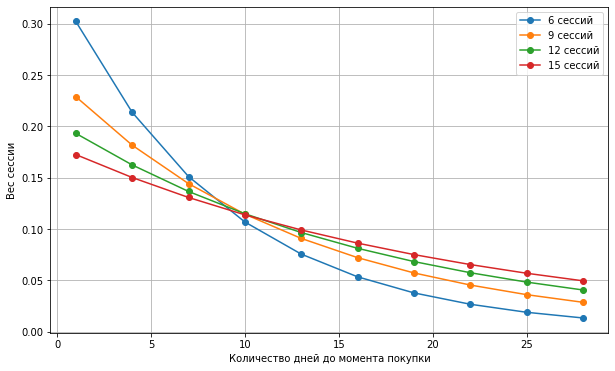

In [2]:
x = list(range(1, 31, 3))

plt.figure(figsize=(10, 6))

for s in range(6, 16, 3): 
    w = [2**(-d / s) for d in x]
    y = [weight / sum(w) for weight in w]  # нормируем, чтобы сумма весов была равна 1
    plt.plot(x, y, '-o', label=f'{s} сессий')

plt.legend(loc='best')
plt.xlabel('Количество дней до момента покупки')
plt.ylabel('Вес сессии')
plt.grid()
plt.show()

In [4]:
session_data = pd.read_csv('data.csv', delimiter=';')

# изменение форматов данных для удобства
session_data['date'] = [datetime.strptime(x, '%Y-%m-%d') for x in session_data['date']]
session_data[['cost', 'value']] = session_data[['cost', 'value']].astype(float)

# группировка и суммирования, чтобы объединить покупки с одинакового канала в один день
session_data = session_data.groupby(['userId', 'date', 'trafficSource'])['cost', 'value'].sum().reset_index()
session_data = session_data.sort_values(by=['userId', 'date'])
session_data.head()

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,userId,date,trafficSource,cost,value
0,user_10,2020-01-05,telegram / posts,15.75,215.0
1,user_10000,2020-01-17,yandex / cpc,8.50,0.0
2,user_10000,2020-01-19,google / cpc,8.25,0.0
3,user_1002,2020-01-03,telegram / posts,15.75,0.0
4,user_1003,2020-01-08,google / cpc,8.25,0.0


In [5]:
purchases_only = session_data[session_data['value'] > 0][['userId', 'date']]
purchases_only = purchases_only.groupby('userId')['date'].max().reset_index()
purchases_only.columns = ['userId', 'purchaseDate']

In [6]:

session_data['totalSessions'] = session_data.groupby('userId')['date'].transform(lambda x: x.count())
session_data['totalValue'] = session_data.groupby('userId')['value'].transform(lambda x: x.sum())
session_data['sessionNumber'] = session_data.groupby('userId').cumcount() + 1

session_data = session_data.merge(purchases_only, on='userId', how='left')

In [7]:
session_data['daysToPurchase'] = [(x - y).days if x else 0
                                  for x, y in zip(session_data['purchaseDate'], session_data['date'])]

session_data['timeDecayWeight'] = [2**(-x / y)
                                   for x, y in zip(session_data['daysToPurchase'], session_data['totalSessions'])]

session_data['timeDecayWeight'] = session_data['timeDecayWeight'] / session_data.groupby('userId')['timeDecayWeight'].transform(lambda x: x.sum())


In [8]:
session_data['lastTouchValue'] = session_data['value']
session_data['firstTouchValue'] = [x if y == 1 else 0
                                   for x, y in zip(session_data['totalValue'], session_data['sessionNumber'])]
session_data['linearValue'] = session_data['totalValue'] / session_data['totalSessions']
session_data['timeDecayValue'] = session_data['totalValue'] * session_data['timeDecayWeight']


In [9]:
print(session_data[['lastTouchValue', 'firstTouchValue', 'linearValue', 'timeDecayValue']].sum())

lastTouchValue     131345.0
firstTouchValue    131345.0
linearValue        131345.0
timeDecayValue     131345.0
dtype: float64


In [10]:

totals = session_data.groupby('trafficSource')[['cost', 'lastTouchValue', 'firstTouchValue', 'linearValue',
                                                'timeDecayValue']].sum()

totals['lastTouchROI'] = 100*(round(totals['lastTouchValue'] / totals['cost'], 4))
totals['firstTouchROI'] = 100*(round(totals['firstTouchValue'] / totals['cost'], 4))
totals['linearROI'] = 100*(round(totals['linearValue'] / totals['cost'], 4))
totals['timeDecayROI'] = 100*(round(totals['timeDecayValue'] / totals['cost'], 4))

totals[['cost', 'lastTouchROI', 'firstTouchROI', 'linearROI', 'timeDecayROI']]

,cost,lastTouchROI,firstTouchROI,linearROI,timeDecayROI
trafficSource,,,,,
facebook / video,28208.00,119.59,136.65,123.62,121.08
google / cpc,25137.75,169.30,163.54,169.77,178.20
telegram / posts,35374.50,82.91,71.97,78.05,78.77
vk / display,4498.75,96.58,103.42,91.51,78.79
yandex / cpc,14025.00,152.42,153.83,157.36,149.64


In [11]:
NEW_BUDGET = 1e6

In [12]:
new_totals = totals.copy()
new_totals['new_budget'] = NEW_BUDGET * new_totals['cost'] / new_totals['cost'].sum()

In [31]:
linearModel = new_totals[['new_budget', 'lastTouchROI', 'linearROI']]

# Заполните строчки ниже вашими расчетами:
linearModel['currentValue'] =  linearModel['new_budget']*linearModel['linearROI']/100
linearModel['delta'] =  linearModel['linearROI'] - linearModel['lastTouchROI']
linearModel['optimalSpend'] = linearModel['new_budget']*(1+linearModel['delta']/100)
linearModel['optimalValue'] =  linearModel['optimalSpend']*linearModel['linearROI']/100

linearModel['profit'] = linearModel['optimalValue'] - linearModel['currentValue']

print(f'Суммарный профит от линейной модели = {round(sum(linearModel["profit"]))}')

linearModel

Суммарный профит от линейной модели = 10682


C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,new_budget,lastTouchROI,linearROI,currentValue,delta,optimalSpend,optimalValue,profit
trafficSource,,,,,,,,
facebook / video,263026.369774,119.59,123.62,325153.198314,4.03,273626.332475,338256.872206,13103.673892
google / cpc,234397.728544,169.30,169.77,397937.023750,0.47,235499.397868,399807.327761,1870.304012
telegram / posts,329850.621014,82.91,78.05,257448.409701,-4.86,313819.880832,244936.416990,-12511.992711
vk / display,41948.733729,96.58,91.51,38387.286235,-5.07,39821.932929,36441.050823,-1946.235412
yandex / cpc,130776.546940,152.42,157.36,205789.974264,4.94,137236.908359,215955.998993,10166.024729


In [ ]:
За счет facebook и yandex линейная модель приенесет больше прибыли.

In [30]:
tdModel = new_totals[['new_budget', 'lastTouchROI', 'timeDecayROI']]

# Заполните строчки ниже вашими расчетами:
tdModel['currentValue'] =  tdModel['new_budget']*tdModel['timeDecayROI']/100
tdModel['delta'] =  tdModel['timeDecayROI'] - tdModel['lastTouchROI']
tdModel['optimalSpend'] =  tdModel['new_budget']*(1+tdModel['delta']/100)
tdModel['optimalValue'] =  tdModel['optimalSpend']*tdModel['timeDecayROI']/100

tdModel['profit'] = tdModel['optimalValue'] - tdModel['currentValue']

print(f'Суммарный профит от time-decay модели = {round(sum(tdModel["profit"]))}')

tdModel

Суммарный профит от time-decay модели = 19843


C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,new_budget,lastTouchROI,timeDecayROI,currentValue,delta,optimalSpend,optimalValue,profit
trafficSource,,,,,,,,
facebook / video,263026.369774,119.59,121.08,318472.328522,1.49,266945.462683,323217.566217,4745.237695
google / cpc,234397.728544,169.30,178.20,417696.752266,8.90,255259.126385,454871.763218,37175.010952
telegram / posts,329850.621014,82.91,78.77,259823.334173,-4.14,316194.805304,249066.648138,-10756.686035
vk / display,41948.733729,96.58,78.79,33051.407305,-17.79,34486.053998,27171.561945,-5879.845360
yandex / cpc,130776.546940,152.42,149.64,195694.024841,-2.78,127140.958935,190253.730950,-5440.293891


In [ ]:
За счет гугл time-decay модель принесет больше прибыли

In [ ]:
Модели показали такие разные результаты, потому что есть большая разница прибыли ресурсов по первому и последнему касанию